#  Matching Catalogs by Proximity with NumCosmo

---
**License**

 Matching Catalogs by Proximity with NumCosmo

 Mon Dec 2 18:30:00 2024\
 Copyright  2024\
 Cinthia Nunes de Lima <cinthia.n.lima@uel.br> \ Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---
 matching_by_proximity\
 Copyright (C) 2024 Cinthia Nunes de Lima <cinthia.n.lima@uel.br>, Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

## Libraries & Configs

In [5]:
import math
import sys

import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table
import pandas as pd

sys.path.insert(0, "/global/homes/c/cinlima/gcrcatalogs-new/gcr-catalogs")
sys.path.insert(0, "/global/homes/c/cinlima/")
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/MachingCatalogs")

from NcSkyMatching import NcSkyMatching

import GCRCatalogs
#Put nersc if using nersc
GCRCatalogs.set_root_dir_by_site("nersc")

print('GCRCatalogs =', GCRCatalogs.__version__, '|' ,'GCR =', GCRCatalogs.GCR.__version__)


from numcosmo_py import Nc, Ncm

Ncm.cfg_init()

import tqdm

# GCRCatalogs.get_available_catalog_names()

GCRCatalogs = 1.9.0 | GCR = 0.9.2


## Catalogs

In [6]:
#Cosmo DC2
cosmodc2= GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')

#Cosmo DC2 + RedMaPPer
catalog_dc2_redmapper = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_redmapper_v0.8.1')

In [9]:
for i in catalog_dc2_redmapper.list_all_quantities():
    if 'redshift' in i:
        print (i)

# print(', '.join(sorted(cosmodc2.list_all_quantities())))


redshift
redshift_err
redshift_true_member
redshift_true_cg


In [ ]:
import re

data = gc.get_quantities([q for q in gc.list_all_quantities() if re.match(r'sed_\d+_\d+$', q)])
list(data.keys())

In [10]:
# Restrictions on richness, mass and redshift
min_richness = 5
min_halo_mass = 1e13 #Msun
redshift_max = 1.2

#cDC2 + RM data
quantities = catalog_dc2_redmapper.list_all_quantities()
cluster_quantities = [q for q in quantities if 'member' not in q]
member_quantities = [q for q in quantities if 'member' in q]
    
query = GCRCatalogs.GCRQuery('(richness > ' + str(min_richness) +')')
cluster_data = Table(catalog_dc2_redmapper.get_quantities(cluster_quantities, [query])) # cDC2 + RM cluster data
member_data = Table(catalog_dc2_redmapper.get_quantities(member_quantities)) # cDC2 + RM member data

#cDC2 data
quantities_wanted = ['redshift','halo_mass','halo_id','galaxy_id','ra','dec', 'is_central']
query = GCRCatalogs.GCRQuery('(halo_mass > ' + str(min_halo_mass) +') & (redshift < ' + str(redshift_max) +') & (is_central < ' + str(redshift_max) +') ')
truth_data = Table(cosmodc2.get_quantities(quantities_wanted, [query]))

In [26]:
# truth_data[truth_data['is_central'] == True]
truth_data[truth_data['halo_id'] == 1915500193286]

is_central,redshift,ra,halo_id,halo_mass,dec,galaxy_id
bool,float64,float64,int64,float64,float64,int64
True,0.6938528022558739,74.18864456687197,1915500193286,18010319222985.918,-46.147101132277875,12063531591
False,0.6940052919399451,74.19625950662343,1915500193286,18010319222985.918,-46.15230614428633,12063531592
False,0.6941812391799049,74.18416773457602,1915500193286,18010319222985.918,-46.13343424302369,12063531593
False,0.6929244982578675,74.19341078134596,1915500193286,18010319222985.918,-46.14313909941326,12063531594
False,0.6940649379394672,74.18292345656629,1915500193286,18010319222985.918,-46.155157761991354,12063531595
False,0.6929906587243495,74.19744734475395,1915500193286,18010319222985.918,-46.14117834043028,12063531596
False,0.6938415513831853,74.17608373413937,1915500193286,18010319222985.918,-46.145308324443555,12063531597
False,0.6942096864900011,74.18242647687327,1915500193286,18010319222985.918,-46.14102802039924,12063531598
False,0.6950496812747564,74.18974895231635,1915500193286,18010319222985.918,-46.15163197139814,12063531599


In [25]:
cluster_data[cluster_data['cluster_id'] == 41339]

p_cen_0,ra,maskfrac,dec_cen_4,ra_cen_0,ra_cen_2,richness,ra_cen_4,ra_cen_1,cluster_id,redshift_true_cg,redshift_err,richness_err,dec_cen_1,dec,dec_cen_2,id_cen_3,redshift,id_cen_1,dec_cen_0,dec_cen_3,p_cen_3,scaleval,id_cen_2,p_cen_4,id_cen_0,p_cen_2,p_cen_1,id_cen_4,ra_cen_3
float32,float64,float32,float64,float64,float64,float32,float64,float64,int32,float32,float32,float32,float64,float64,float64,int64,float32,int64,float64,float64,float32,float32,int64,float32,int64,float32,float32,int64,float64
0.9763951,53.46292368544768,0.0,-45.13212876090004,53.46292368544768,53.48551434249019,5.2671795,53.44740614348428,53.50290245885472,41339,0.12456173,0.0071628466,1.2773417,-45.229915961636024,-45.19317372744965,-45.24676640433799,11625004505,0.12825155,11625004504,-45.19317372744965,-45.16080132898102,4.3574695e-07,1.0002445,11625002074,2.2487037e-09,11625004501,5.2151707e-05,0.02355235,11625005427,53.42879185779369


## Matching by Proximity

In [82]:
halo_data = truth_data[truth_data['is_central'] == True]
z1 = halo_data['redshift']
theta1= np.radians(halo_data['dec'])
phi1 = np.radians(halo_data['ra'])

z2 = cluster_data['redshift']
theta2 = cluster_data['dec']
phi2 = cluster_data['ra']

# truth_data.write('halo_data.fits') 

In [88]:
halo_data

redshift,dec,halo_id,halo_mass,is_central,ra,galaxy_id
float64,float64,int64,float64,bool,float64,int64
0.04818676962281132,-40.400894272468605,4500151475,16891355712901.41,True,49.6366034309591,9437500128
0.04825926322238838,-41.3447799174979,7300151475,74621860826501.4,True,50.957598308861314,9437500172
0.04554516035339984,-40.832338501224754,13700151475,33506664194163.383,True,51.00887984172898,9437500288
0.0643846735498792,-41.15855360868742,1100151464,17911434075583.098,True,50.57641425057562,9437500798
0.10736840205357634,-39.168679326038024,18300151442,13042641686354.93,True,50.77601162448169,9437504902
0.12743613052494784,-39.336294511446724,36400151442,48388878878287.33,True,50.60510200022939,9437505130
0.11375834498747261,-40.23977306100707,43700151442,69213477135143.664,True,49.50475455575477,9437505232
0.1259639067546261,-39.64548257286864,52300151442,62974036412214.086,True,51.070122482361214,9437505371
0.12775858760889358,-39.09754001831282,1200151432,34125997485791.55,True,50.36982165635327,9437509536


In [83]:
snn = Ncm.SphereNN()
cosmo = Nc.HICosmoDEXcdm()
dist = Nc.Distance.new(3.0)
dist.prepare(cosmo)

# r_a = np.array([dist.comoving(cosmo, z) for z in z1])

# snn.insert_array(r_a, theta1, phi1)
# snn.rebuild()


# ind = []
# for i, (theta, phi, z) in tqdm.tqdm(
#     enumerate(zip(theta2, phi2, z2)), total=len(theta2)
#     ):
#     r = dist.comoving(cosmo, z)
#     indices = np.array(snn.knn_search(r, theta, phi, 5))
    

In [ ]:
halo_names = {"RA": 'ra' , "DEC": "dec" , "z": 'redshift'}
halo_property = {"mass": "halo_mass"}
cluster_names = {"RA": 'ra' , "DEC": "dec" , "z": 'redshift'}
cluster_property = {"richness":'richness'}

test = NcSkyMatching(cat1="halo_data.fits", cat1_coordinates=halo_names, cat2="cluster_data.fits", 
                                   cat2_coordinates=cluster_names, cat1_properties=halo_property, cat2_properties=cluster_property)

matches = test.process_halos(cosmo=cosmo , matching_distance=1, n_nearest_neighbours=10, match_file="test.fits")

In [12]:
mdata = Table.read('test.fits')
mdata

ID,RA,DEC,z,ID_matched,RA_matched,DEC_matched,z_matched,distances Mpc,mass,richness
int64,float64,float64,float32,object,object,object,object,object,object,float32
0,52.520436430812914,-25.717996124671657,0.5135129,[1257983.],[52.51421229],[-25.70845685],[0.51349377],[0.39320361],[5.46154289e+14],190.70665
1,56.920376528125075,-27.20434071042304,0.5712697,[1601312.],[56.92027236],[-27.20381396],[0.57123694],[0.1087216],[1.00953537e+15],179.12813
2,56.99849698116052,-26.7172081871169,1.040338,[4904818.],[56.99678924],[-26.71643078],[1.04040836],[0.20320977],[2.89475385e+13],124.02715
3,58.56362402841767,-27.429961828331713,0.63518524,[1606532.],[58.56328785],[-27.40997922],[0.63534048],[0.96988225],[3.88491914e+14],167.33603
4,58.35519782866568,-26.867687128773035,0.44230303,[1596785.],[58.35345232],[-26.86448605],[0.44228231],[0.13156795],[3.56926173e+14],111.9147
5,57.76575707007693,-28.119101936484828,0.46697217,[1597957.],[57.76346932],[-28.11657909],[0.46702997],[0.22592255],[3.58202423e+14],104.439766
6,58.509466974185045,-26.989676182075844,0.4413634,[1595669.],[58.497715],[-27.00358319],[0.44125815],[0.65042407],[4.36869867e+14],103.49396
7,54.494027152041674,-27.896589555863095,1.0629631,[4896403.],[54.49391401],[-27.8947772],[1.06317824],[0.53638431],[2.53118449e+14],76.85877
8,58.137368555958155,-27.199784884537003,1.037697,[4903474.],[58.13075023],[-27.20154935],[1.03757698],[0.48076345],[3.40049002e+14],75.89771


In [103]:
data = mdata[mdata['mass'] > 0]
mt_data = Table([[m[0] for m in data['mass']], [l for l in data['richness']], [r for r in data['z']]], names=('mass', 'richness', 'z'))

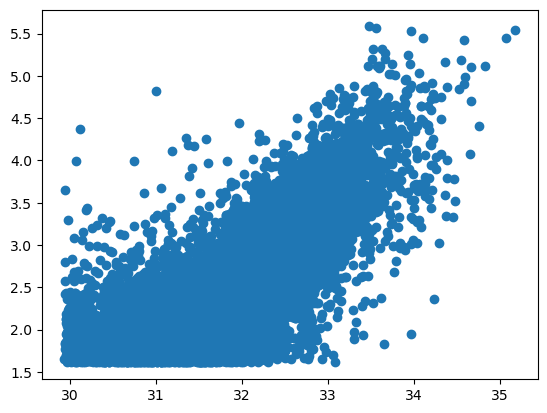

In [129]:
plt.scatter(np.log(mt_data['mass']), np.log(mt_data['richness']))